This section describes the code behind training our convolutional neural network for recognizing hot dog vs non-hot dogs.

### Importing libraries and defining paths and constants

In [135]:
import os
import argparse
import simplejson
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input

keras.backend.clear_session()

Like before, we define the data file path and some important constants including the batch size and image size ($299$ x $299$ pixels). 

In [112]:
#define paths and constants
cwd = os.getcwd()
data_path = os.path.join(cwd, 'data')
#data_path = "/Users/victorialiu/git/creatica/code/data/"
batch_size = 32
TARGET_SIZE = 299

### Command Line Argument Parser
We want to be able to run our code from the command line (at least in the `.py` version of this notebook), so we use an argument parser to translate command line arguments. We require a model name when running the script, as well as what we want the regularizer strength to be (default to $0$). As we'll see later, having a model name makes it much easier to compare models. By the end of the Hackathon, we'll compare four different models and select the best one for deployment.

In [113]:
## Parse command line arguments
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-m', '--model-name',
        help='prefix for file to save trained model to ' +
            '(e.g. dense_arch1, conv_regularize05, etc.)',
        required=True)
    parser.add_argument('-r', '--regularizer-strength',
        help='strength of l2 regularization to use',
        type=float, default=0.00)

    return parser.parse_args()

### Image Pre-processing with InceptionV3 net
Next, we do data augmentation in order to "create" more data to train from. Data augmentation includes shifting the image in small ways such that the same image can be trained from multiple perspective (i.e. a rotated image of a hot dog is still a hot dog, and now we'll have more training data). We also make sure to normalize the image by dividing by the maximum pixel value of $255$. We also write a helper function to easily call based on whether we are using testing or training data.

In [114]:
def image_data_augment(rescale=1/255, shear_range = False, zoom_range = False, horizontal_flip = False):
    #declare ImageDataGenerator class for augmenting images using shear, zoom, and flips
    #normalize with 1./255
    return (ImageDataGenerator(
            rescale=rescale,
            shear_range=shear_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip))

def get_images(train_or_test):
    if train_or_test == 'train':
        datagen = image_data_augment(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
    else:
        datagen = image_data_augment()
        
    generator = datagen.flow_from_directory(
        os.path.join(data_path, train_or_test),
        target_size=(TARGET_SIZE, TARGET_SIZE),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    return generator
# gen = get_images('train')
# a = gen[1273]
# a = np.array(a)
# a = np.reshape(a, (299, 299, 3))
# plt.imshow(a)
# gen.filenames[1274]

In the effort of saving time training the model (which could take overnight and use up precious time) and making the model as accurate as possible, we use transfer learning, where we piggy-back on a pre-trained CNN model that will extract out important features of our data through the bottleneck in the network. We use InceptionV3, and the standard image pre-processing pipeline will always include feeding it through InceptionV3 first. This will make prediction a little slower, but the accuracy and significantly decreased training time (order of minutes) is so worth it. Lastly, we write function `get_data()` that calls all the previous image-preprocessing helper functions to streamline the process.

In [1]:
def preprocess_inception():
    """
    inception for transfer learning
    """
    #transfer learning with InceptionV3, a pre-trained cnn
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE, TARGET_SIZE, 3))
    
    for train_or_test in ['train', 'test']:
        generator = get_images(train_or_test)

        bottleneck_features = model.predict(generator, len(generator), verbose=1)
        
        #save model with the bottleneck features
        np.savez(f'inception_features_{train_or_test}', features=bottleneck_features)
    
    return True



def get_data():
    #augment images and use inception net
    preprocess_inception()

    #load training data and define labels, where 0 is hotdog and 1 is nothotdog
    train_data = np.load('inception_features_train.npz')['features']

    #requires the number of hotdog and nothotdog samples to be the exact same
    train_data_type_count = int(len(train_data) / 2)
    train_labels = np.array([0] * train_data_type_count + [1] * train_data_type_count)

    #load testing data and define labels, where 0 is hotdog and 1 is nothotdog
    test_data = np.load('inception_features_test.npz')['features']

    #requires the number of hotdog and nothotdog samples to be the exact same
    test_data_type_count = int(len(test_data) / 2)
    test_labels = np.array([0] * test_data_type_count + [1] * test_data_type_count)
    
    return (train_data, train_labels, test_data, test_labels)


### Convolutional Neural Network
Now, we get to the heart of our machine learning model! After being passed through InceptionV3, the feature-extracted version of the image is passed through our own convolutional network. This CNN was largely taken from [J-Yash's open-source code](https://github.com/J-Yash/Hotdog-Not-Hotdog), but we added a regularizer (`reg_param`), which notably can be inputted from the command line. We also commented the code significantly to clarify what each line does.

In [6]:
def build_conv_net(reg_param, train_data_shape):
    #train_data_shape = train_data.shape[1:] = (8, 8, 2048)
    model = Sequential()
    
    #convolutional layer with 32 3x3 trainable filters, using rectified linear units.
    #Padding to result in the same shape as the original picture. Add reg_param if true
    #use l2 regularization if reg_param is given in command line
    model.add(Conv2D(
        32, (3, 3),
        activation='relu',
        input_shape=train_data_shape,
        padding='same',
        kernel_regularizer=l2(reg_param)
    ))
    
    # convolutional layer with 32 3x3 trainable filters, using rectified linear units.
    # Padding to result in the same shape as the original picture.
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    
    # max pooling for noise reduction
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    # dropout for more regularization
    model.add(Dropout(0.25))

    # second block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.50))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # use softmax for multi-class classifications
    # (i.e. model.add(Activation('softmax')))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


### Ready to go
The `main()` function is mainly for the command line, but it can also be run from Jupyter if the right lines are commented out. Notably, we use the Adam optimizer, we calculate loss based on binary cross-entropy, and we calculate accuracy based on the binary accuracy. Notably, we also have a checkpointer, so that we only save the best model after multiple epochs. The best model is defined the model in which the validation error is the lowest, not the training error. We have a 30/70% training vs. validation split, which is generally a good rule of thumb, and we choose $8$ epochs since the accuracy generally peaks within the first $5$ epochs... The saved model is saved as a `.h5` and `.json` file under `creatica/code/model`, so that we can load it in another module. Finally, we output a graph of the loss and accuracy metrics, compared between training and validation sets. The image is actually saved to the `/creatica/code/img` folder, but it also pops up when the script is run from the command line.

Found 588 images belonging to 2 classes.
19/19 [==============================] - 21s 1s/step
Found 282 images belonging to 2 classes.
9/9 [==============================] - 10s 1s/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_482 (Conv2D)          (None, 8, 8, 32)          589856    
_________________________________________________________________
conv2d_483 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_484 (Conv2D)          (None, 2, 2, 64)          18496     
_________________________________________________________________


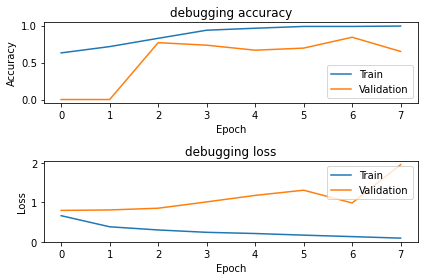

In [20]:
def main():
    
# comment this out when running from command line!
    model_name = 'demo'
    regularizer_strength = .00001

# #     comment out when not running from cmdline
#     ## get cmdline args
#     args = parse_args()
#     model_name = args.model_name
#     # get regularization strength, if defined. Otherwise, it is 0
#     regularizer_strength = args.regularizer_strength


    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)
    plot_fname = os.path.join(cwd, 'img', '%s_learn.png' % model_name)

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', model_name + '.h5')
    model_json_fname = os.path.join(cwd, 'model', model_name + '.json')


    # Importing the hotdog dataset
    #may take a few seconds
    (train_data, train_labels, test_data, test_labels) = get_data()
    train_data_shape = train_data.shape[1:]

    

    # build model
    model = build_conv_net(regularizer_strength, train_data_shape)
    
    # Print a summary of the layers and weights in the model
    model.summary()

    # Have our model minimize the binary cross entropy loss with the adam
    # optimizer (fancier stochastic gradient descent that converges faster)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy']
                 )

    # #set checkpointer to use in callback, to only keep the best model weights
    checkpointer = ModelCheckpoint(
        filepath='/Users/victorialiu/git/creatica/tmp',
        verbose=1, 
        save_weights_only=True,
        )

    #time to fit
    history = model.fit(train_data, train_labels,
            epochs=8,
            batch_size=batch_size,
            validation_split=0.3,
            verbose=2,
            callbacks=[checkpointer],
            shuffle=True)



    #load best model
    model.load_weights('/Users/victorialiu/git/creatica/tmp')

    # Save model weights and json spec describing the model's architecture
    model.save(model_weights_fname)
    model_json = model.to_json()
    with open(model_json_fname, 'w') as f:
        f.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

        

    # Plot accuracy learning curve
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('%s accuracy' % model_name)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.savefig(plot_fname)

    # Plot loss learning curve
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s loss' % model_name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(plot_fname)
    plt.show()


main()

**Authors**: Victoria Liu and Gloria Liu

**Last modified**: November 2020

Description: A script to train and save a neural net to recognize hot dogs vs.
non-hot dogs.

**Credits** Parts of the code are originally part of a Caltech extra credit assignment (CS 156a), where
Aadyot Bhatnagar wrote the parse_args() and main() functions. The conv-net code is heavily modified from [J-Yash's open-source code](https://github.com/J-Yash/Hotdog-Not-Hotdog). All markdown is done by Victoria / Gloria.
